# Monocular Depth Estimation 

### Imports

%matplotlib inline will plot the graphs along with the code

In [10]:
import math
import h5py
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision.models import vgg16
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device('cpu')
print(device)
%matplotlib inline 
import torch.nn.functional as F

cpu


### Dataset class

In [11]:
class NYUDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, tfms):
        super(NYUDataset, self).__init__()
        self.data_dir = data_dir
        self.tfms = tfms
        
        self.ds_v_1 = h5py.File(self.data_dir+'nyu_depth_data_labeled.mat')
        self.ds_v_2 = h5py.File(self.data_dir+'nyu_depth_v2_labeled.mat')
        
        self.len = len(self.ds_v_1["images"]) + len(self.ds_v_2["images"])

           
    def __getitem__(self, index):
        if(index<len(self.ds_v_1["images"])):
            ds = self.ds_v_1    
            i = index
        else:    
            ds = self.ds_v_2
            i = index - len(self.ds_v_1["images"])

        img = np.transpose(ds["images"][i], axes=[2,1,0])
        img = img.astype(np.uint8)

        depth = np.transpose(ds["depths"][i], axes=[1,0])
        depth = (depth/depth.max())*255
        depth = depth.astype(np.uint8)

        if self.tfms:
            tfmd_sample = self.tfms({"image":img, "depth":depth})
            img, depth = tfmd_sample["image"], tfmd_sample["depth"]
        return (img, depth)
    
    def __len__(self):
        return self.len    

### Custom transforms

In [12]:
class ResizeImgAndDepth(object):
    def __init__(self, size_tup):
        self.size = size_tup
        
    def __call__(self, sample):
        img = Image.fromarray(sample['image'],  'RGB').resize(self.size)
        depth = Image.fromarray(sample['depth'], 'L').resize((self.size[0]//2, self.size[1]//2))
        return { 'image' : np.array(img), 'depth' : np.array(depth) }

class RandomHorizontalFlip(object):    
    def __call__(self, sample):
        img = sample["image"]
        depth = sample["depth"]
        if np.random.random() > 0.5:
            img = np.fliplr(sample['image']).copy()
            depth = np.fliplr(sample['depth']).copy()
        return { 'image' : img, 'depth' : depth }
       
class ImgAndDepthToTensor(object):        
    def __init__(self):
        self.ToTensor = transforms.ToTensor()
        
    def __call__(self, sample):        
        return { 'image' : self.ToTensor(sample['image']), 'depth' : torch.tensor(sample['depth'], dtype=torch.float) }      
    
class NormalizeImg(object):
    def __init__(self, mean, std):
        self.normalize = transforms.Normalize(mean, std)
    
    def __call__(self, sample):
        return { 'image' : self.normalize(sample['image']), 'depth' : sample['depth'] }

class UnNormalizeImgBatch(object):
    def __init__(self, mean, std):
        self.mean = mean.reshape((1,3,1,1))
        self.std = std.reshape((1,3,1,1))
    
    def __call__(self, batch):
        return (batch*self.std) + self.mean

### Model utils and Loss function

In [13]:
def get_unnormalized_ds_item(unnormalize, item):
    un_img = unnormalize(item[0][None])  
    return (un_img.squeeze(dim=0), item[1])

def freeze_all_layers(model):
    for param in model.parameters():
        param.requires_grad = False
        
def unfreeze_all_layers(model):
    for param in model.parameters():
        param.requires_grad = True        

def get_model_predictions_on_a_sample_batch(model, dl):
    model.eval()
    with torch.no_grad():
        batch, actual_labels = iter(dl).next()
        batch = batch.to(device)
        actual_labels = actual_labels.to(device)
        predictions = model(batch)
    
    return (predictions, batch, actual_labels)


def im_gradient_loss(d_batch, n_pixels):
    a = torch.Tensor([[[[1, 0, -1],
                      [2, 0, -2],
                      [1, 0, -1]]]])
                      
    b = torch.Tensor([[[[1, 2, 1],
                      [0, 0, 0],
                      [-1, -2, -1]]]])
    a = a.to(device)
    b = b.to(device)
    
    G_x = F.conv2d(d_batch, a, padding=1).to(device)
    G_y = F.conv2d(d_batch, b, padding=1).to(device)
    
    G = torch.pow(G_x,2)+ torch.pow(G_y,2)
    
    return G.view(-1, n_pixels).mean(dim=1).sum()

def depth_loss(preds, actual_depth):
    #preds.shape        -> [16, 1, 120, 160]
    #actual_depth.shape -> [16, 120, 160]
    n_pixels = actual_depth.shape[1]*actual_depth.shape[2]
    
    preds = (preds*0.225) + 0.45
    preds = preds*255
    preds[preds<=0] = 0.00001
    actual_depth[actual_depth==0] = 0.00001
    actual_depth.unsqueeze_(dim=1)
    d = torch.log(preds) - torch.log(actual_depth)

    grad_loss_term = im_gradient_loss(d, n_pixels)
    term_1 = torch.pow(d.view(-1, n_pixels),2).mean(dim=1).sum() #pixel wise mean, then batch sum
    term_2 = (torch.pow(d.view(-1, n_pixels).sum(dim=1),2)/(2*(n_pixels**2))).sum()
    
    return term_1 - term_2 + grad_loss_term

def print_training_loss_summary(loss, total_steps, current_epoch, n_epochs, n_batches, print_every=10):
    #prints loss at the start of the epoch, then every 10(print_every) steps taken by the optimizer
    steps_this_epoch = (total_steps%n_batches)
    
    if(steps_this_epoch==1 or steps_this_epoch%print_every==0):
        print ('Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}' 
               .format(current_epoch, n_epochs, steps_this_epoch, n_batches, loss))


def apply_sobel_operator_on_sample_ds_image(ds_item, unnormalize, T, P):
    x = unnormalize(ds_item[0][None]) #send x as a batch of 1 item
    x_bw = P(x[0]).convert('L')
    x = T(x_bw)[None]

    #Black and white input image x, 1x1xHxW
    a = torch.Tensor([[1, 0, -1],
                      [2, 0, -2],
                      [1, 0, -1]])

    a = a.view((1,1,3,3))
    G_x = F.conv2d(x, a, padding=1)

    b = torch.Tensor([[1, 2, 1],
                      [0, 0, 0],
                      [-1, -2, -1]])

    b = b.view((1,1,3,3))
    G_y = F.conv2d(x, b, padding=1)

    G = torch.sqrt(torch.pow(G_x,2)+ torch.pow(G_y,2))
    return G_x[0], G_y[0], G[0]

### Plot Utils

In [14]:
def plot_image(tup):
    img_tensor, depth_tensor = tup
    fig, axes = plt.subplots(1, 2, figsize=(10,15))
    for i,ax in enumerate(axes.flat):
        if(i==0):
            plot_image_tensor_in_subplot(ax, img_tensor)
        else:
            plot_depth_tensor_in_subplot(ax, depth_tensor)
        hide_subplot_axes(ax)

    plt.tight_layout()
    
#subplot utils    
def hide_subplot_axes(ax):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

def plot_image_tensor_in_subplot(ax, img_tensor):
    im = img_tensor.cpu().numpy().transpose((1,2,0))
    #pil_im = Image.fromarray(im, 'RGB')
    ax.imshow(im)

def plot_depth_tensor_in_subplot(ax, depth_tensor):
    im = depth_tensor.cpu().numpy()
    #im = im*255
    #im = im.astype(np.uint8)
    #pil_im = Image.fromarray(im, 'L')
    ax.imshow(im,'gray')
    
def plot_model_predictions_on_sample_batch(images, depths, preds, plot_from=0, figsize=(12,12)):
    n_items=5
    fig, axes = plt.subplots(n_items, 3, figsize=figsize)
    
    for i in range(n_items):
        plot_image_tensor_in_subplot(axes[i,0], images[plot_from+i])
        plot_depth_tensor_in_subplot(axes[i,1], depths[plot_from+i])
        plot_depth_tensor_in_subplot(axes[i,2], preds[plot_from+i])
        hide_subplot_axes(axes[i,0])
        hide_subplot_axes(axes[i,1])
        hide_subplot_axes(axes[i,2])
    
    plt.tight_layout()

### Model

In [15]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    
    def forward(self, batch):
        return batch.view([batch.shape[0], -1])


class Scale1_Linear(nn.Module):
    #input 512x7x10
    #output 64x15x20
    
    def __init__(self):
        super(Scale1_Linear, self).__init__()
        self.block = nn.Sequential(
            Flatten(),
            nn.Linear(512*7*10, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 64*15*20)
        )
    
    def forward(self, x):
        scale_1_op = torch.reshape(self.block(x), (x.shape[0], 64, 15, 20))
        return nn.functional.interpolate(scale_1_op, scale_factor=4, mode='bilinear', align_corners=True)


class Scale2(nn.Module):
    #input 64x60x80, 3x240x320
    #output 1x120x160
    
    def __init__(self):
        super(Scale2, self).__init__()
        self.input_img_proc = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, padding=4, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
            
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=64+64, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=5, padding=2)
        )
    
    def forward(self, x, input_img):
        proc_img = self.input_img_proc(input_img)
        concatenate_input = torch.cat((x,proc_img), dim=1)
        return nn.functional.interpolate(self.block(concatenate_input), scale_factor=2, mode='bilinear', align_corners=True)


class Scale3(nn.Module):
    #input 1x120x160, 3x240x320
    #output 1x120x160
    
    def __init__(self):
        super(Scale3, self).__init__()
        self.input_img_proc = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, padding=4, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
            
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=65, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=5, padding=2)
        )
    
    def forward(self, x, input_img):
        proc_img = self.input_img_proc(input_img)
        concatenate_input = torch.cat((x,proc_img), dim=1)
        return self.block(concatenate_input)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.VGG = nn.Sequential(*list(vgg16(pretrained=True).children())[0])
        self.Scale_1 = Scale1_Linear()
        self.Scale_2 = Scale2()
        self.Scale_3 = Scale3()
    
    def forward(self, x):
        input_img = x.clone()                  # 3x240x320
        x = self.VGG(x)                        # 512x7x10
        x = self.Scale_1(x)                    # 64x60x80
        x = self.Scale_2(x, input_img.clone()) # 1x120x160
        x = self.Scale_3(x, input_img.clone()) # 1x120x160
        return x

### Loading dataset using dataset class and data loader 

In [17]:
bs = 8
sz = (320,240)
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
mean, std = torch.tensor(mean), torch.tensor(std)
unnormalize = UnNormalizeImgBatch(mean, std)

tfms = transforms.Compose([
    ResizeImgAndDepth(sz),
    RandomHorizontalFlip(),
    ImgAndDepthToTensor(),
    NormalizeImg(mean, std)
])

ds = NYUDataset('data/', tfms)
dl = torch.utils.data.DataLoader(ds, bs, shuffle=True)

<ipython-input-11-b05c3d3a1d7a>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.ds_v_1 = h5py.File(self.data_dir+'nyu_depth_data_labeled.mat')
<ipython-input-11-b05c3d3a1d7a>:8: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.ds_v_2 = h5py.File(self.data_dir+'nyu_depth_v2_labeled.mat')


### Mapping the model to our device (to CUDA if available)

In [18]:
model = Net()
model.to(device)

Net(
  (VGG): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

### Model Training and parameters

In [20]:
model.train()
n_epochs = 1
lr = 0.0000005
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = lr)

total_steps = 0
for e in range(n_epochs):
    torch.cuda.empty_cache()
    for batch, labels in dl:
        optimizer.zero_grad()
        
        batch = batch.to(device)
        labels = labels.to(device)
        
        preds = model(batch)
        loss = depth_loss(preds, labels) 
        
        loss.backward()
        optimizer.step()
        
        total_steps +=1
                                                       
        print_training_loss_summary(loss.item(), total_steps, e+1, n_epochs, len(dl))

Epoch [1/1], Iteration [1/467], Loss: 46.4561
Epoch [1/1], Iteration [10/467], Loss: 26.4875
Epoch [1/1], Iteration [20/467], Loss: 30.9067
Epoch [1/1], Iteration [30/467], Loss: 42.4412
Epoch [1/1], Iteration [40/467], Loss: 20.2522
Epoch [1/1], Iteration [50/467], Loss: 24.4088
Epoch [1/1], Iteration [60/467], Loss: 28.0947
Epoch [1/1], Iteration [70/467], Loss: 25.8837
Epoch [1/1], Iteration [80/467], Loss: 32.8932
Epoch [1/1], Iteration [90/467], Loss: 20.3065
Epoch [1/1], Iteration [100/467], Loss: 36.5659
Epoch [1/1], Iteration [110/467], Loss: 16.7951
Epoch [1/1], Iteration [120/467], Loss: 22.3788
Epoch [1/1], Iteration [130/467], Loss: 23.4199
Epoch [1/1], Iteration [140/467], Loss: 23.3922
Epoch [1/1], Iteration [150/467], Loss: 22.3541
Epoch [1/1], Iteration [160/467], Loss: 25.0096
Epoch [1/1], Iteration [170/467], Loss: 22.1004
Epoch [1/1], Iteration [180/467], Loss: 21.5749
Epoch [1/1], Iteration [190/467], Loss: 22.2033
Epoch [1/1], Iteration [200/467], Loss: 16.6941
Epo

### Saving the model and presenting the results

In [ ]:
#torch.save(model.state_dict(),'all-scales-trained.ckpt')

In [21]:
%%time
with torch.no_grad():
    model.eval()
    img, depth = iter(dl).next()
    preds = model(img.to(device))

Wall time: 3.38 s


In [ ]:
print(img)

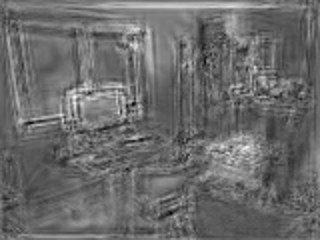

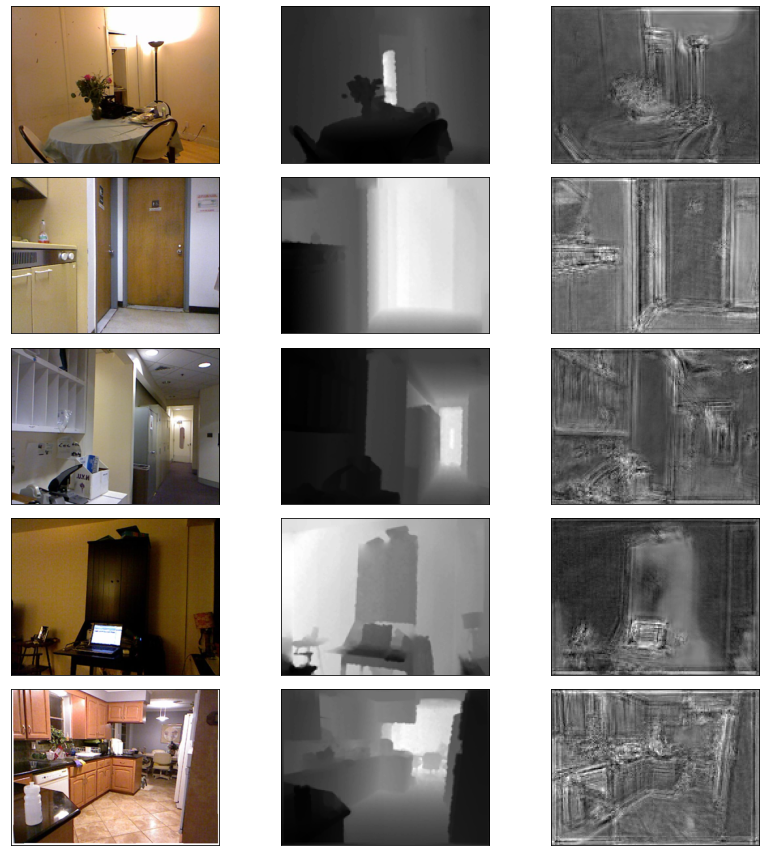

In [22]:
plot_model_predictions_on_sample_batch(images=unnormalize(img), depths=depth, preds=preds.squeeze(dim=1), plot_from=0)

test_tfms = transforms.Compose([
    transforms.Resize((240,320)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

im = Image.open('IMG_4120.jpg').rotate(180)
res = test_tfms(im)

model.eval()
pred = model(res[None].to(device))

pred_numpy_arr = pred.detach().squeeze(dim=1).squeeze(dim=0).cpu().numpy()
pred_numpy_arr = pred_numpy_arr - pred_numpy_arr.min()       # -0.660375
pred_numpy_arr = (pred_numpy_arr/pred_numpy_arr.max())*255   # max = 2.1548061, brings scale to 0-255  
pred_numpy_arr = pred_numpy_arr.astype('uint8')

import PIL

im.resize((320,240), resample=PIL.Image.BILINEAR)

Image.fromarray(pred_numpy_arr, mode = 'L').resize((320, 240))

In [ ]:
from IPython.display import FileLink
FileLink('all-scales-trained.ckpt')